# Sesión 6, Cassandra, 25-26, Bases de Datos a Gran Escala

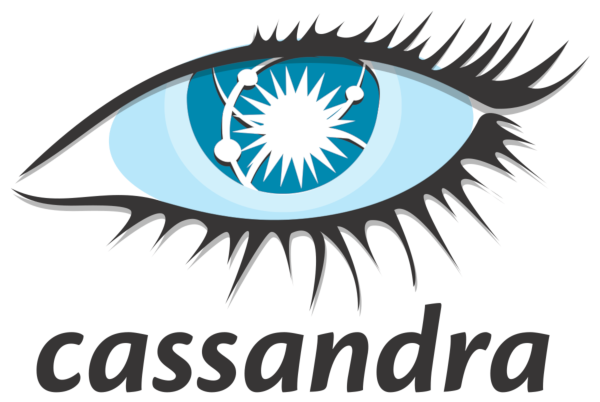

Esta hoja muestra cómo acceder a la base de datos Cassandra y también a conectar la salida con Jupyter.

Con Cassandra vamos a simular un modo semi-clúster con una sola máquina.

In [ ]:
RunningInCOLAB: bool = (
    "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
)

In [ ]:
if RunningInCOLAB:
    !sudo apt-get update && sudo apt-get install -y default-jdk-headless --no-install-recommends

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,835 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [ ]:
if RunningInCOLAB:
    # Search for the first java interpreter. This code should work. If not, adjust JAVA_HOME manually.
    import os
    from pathlib import Path

    def find_java_home() -> str | None:
        p = Path("/usr/lib/jvm")
        (_, dirs, _) = next(os.walk(p))
        for d in dirs:
            inner_java: Path = p / d / "bin" / "java"
            if inner_java.is_file() and inner_java.stat().st_mode & 0o111:
                return str(p.joinpath(d).absolute())
        return None

    JAVA_HOME: str | None = os.getenv("JAVA_HOME", find_java_home())
    %env JAVA_HOME=$JAVA_HOME

env: JAVA_HOME=/usr/lib/jvm/java-1.17.0-openjdk-amd64


## Instalación de Apache Cassandra (sólo Google Colab)

Descargamos el ejecutable comprimido desde su página oficial. Sólo si estamos en Colab. En las ejecuciones con Docker o en las pruebas en entornos de CI que tengo implementados, cassandra está ejecutándose en otro ordenador o en otro contenedor.

In [ ]:
if RunningInCOLAB:
    # Determinar qué versión 5.x.x de Cassandra es la más reciente.
    import re
    from re import Pattern
    from urllib.request import Request, urlopen

    from bs4 import BeautifulSoup

    version_re: Pattern = re.compile(r"^(5\.[0-9]+(\.[0-9]+)?)")
    req = Request("https://dlcdn.apache.org/cassandra/")
    html_page = urlopen(req)

    soup = BeautifulSoup(html_page)
    bigger5x: str = max(
        *[
            m.group(0)
            for m in [version_re.match(link.get_text()) for link in soup.find_all("a")]
            if m
        ],
        "5.0.0",
    )  # Base version 5.x.x
    %env CASSANDRA_VER=$bigger5x

env: CASSANDRA_VER=5.0.6


Descarga de Cassandra y de su firma digital SHA256 para comprobar que el fichero es correcto. Si es correcto, se descomprime. Esto sólo se realiza en Google Colab.

In [ ]:
if RunningInCOLAB:
    import hashlib
    import os
    import tarfile
    import urllib.request
    from typing import cast

    # Descargar Cassandra y su firma digital SHA256
    cassandra_version: str = os.getenv("CASSANDRA_VER", "5.0.0")
    urllib.request.urlretrieve(
        f"https://dlcdn.apache.org/cassandra/{cassandra_version}/apache-cassandra-{cassandra_version}-bin.tar.gz",
        f"apache-cassandra-{cassandra_version}-bin.tar.gz",
    )
    urllib.request.urlretrieve(
        f"https://dlcdn.apache.org/cassandra/{cassandra_version}/apache-cassandra-{cassandra_version}-bin.tar.gz.sha256",
        f"apache-cassandra-{cassandra_version}-bin.tar.gz.sha256",
    )

    # Comprobar la firma digital SHA256
    sha256_hash = hashlib.sha256()
    with open(f"apache-cassandra-{cassandra_version}-bin.tar.gz", "rb") as f:
        # Read and update hash string value in blocks of 4K
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(cast(bytes, byte_block))
    with open(f"apache-cassandra-{cassandra_version}-bin.tar.gz.sha256") as f:
        expected_hash: str = f.read().split()[0]
    if sha256_hash.hexdigest() != expected_hash:
        raise ValueError("Downloaded Cassandra binary does not match the expected SHA256 hash.")

    # Descomprimir Cassandra
    with tarfile.open(f"apache-cassandra-{cassandra_version}-bin.tar.gz", "r:gz") as tar:
        tar.extractall()

/tmp/ipython-input-180084550.py:32: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Dependiendo de la versión de Java, hay que ejecutar Cassandra con un parámetro adicional.

In [ ]:
if RunningInCOLAB:
    javav = !javap -verbose java.lang.String | grep "major version" | cut -d ' ' -f 5
    cassandra_opts: str = ""
    if int(javav[0]) > 55:
        cassandra_opts = "-Djava.security.manager=allow"
    %env CASSANDRA_OPTS=$cassandra_opts

env: CASSANDRA_OPTS=-Djava.security.manager=allow


Hay que cambiar cuestiones de la configuracion de Cassandra para permitir *batches* más grandes:

In [ ]:
if RunningInCOLAB:
    import os
    import re

    config_file: str = f"apache-cassandra-{os.environ['CASSANDRA_VER']}/conf/cassandra.yaml"

    # Read the configuration file
    with open(config_file) as f:
        content = f.read()

    # Apply the same replacements as the sed command
    content: str = re.sub(r"(tombstone_failure_threshold:).*", r"\1 100000", content)
    content = re.sub(r"(batch_size_warn_threshold:).*", r"\1 128KiB", content)
    content = re.sub(r"(batch_size_fail_threshold:).*", r"\1 1024KiB", content)
    content = re.sub(r"(materialized_views_enabled:).*", r"\1 true", content)

    # Write back the modified content
    with open(config_file, "w") as f:
        f.write(content)

Arracamos la base de datos (el parámetro `-R` ejecuta el servidor en segundo plano y además permite ejecutarlo como `root`).

In [ ]:
if RunningInCOLAB:
    !(cd apache-cassandra-${CASSANDRA_VER}/ && sudo bin/cassandra -R ${CASSANDRA_OPTS})

CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.deserializeLargeSubset(Lorg/apache/cassandra/io/util/DataInputPlus;Lorg/apache/cassandra/db/Columns;I)Lorg/apache/cassandra/db/Columns; bool dontinline = true
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubset(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;ILorg/apache/cassandra/io/util/DataOutputPlus;)V bool dontinline = true
CompileCommand: dontinline org/apache/cassandra/db/Columns$Serializer.serializeLargeSubsetSize(Ljava/util/Collection;ILorg/apache/cassandra/db/Columns;I)I bool dontinline = true
CompileCommand: dontinline org/apache/cassandra/db/commitlog/AbstractCommitLogSegmentManager.advanceAllocatingFrom(Lorg/apache/cassandra/db/commitlog/CommitLogSegment;)V bool dontinline = true
CompileCommand: dontinline org/apache/cassandra/db/transform/BaseIterator.tryGetMoreContents()Z bool dontinline = true
CompileCommand: dontinline org/apache/cassandra/db/transform/S

Con el comando `nodetool status` podemos ver que nuestro cluster contiene un unico datacenter, con un único host. Hacemos un bucle para esperar hasta que esté disponible, porque la inicialización lleva un tiempo.

In [ ]:
import os

CASSANDRA_HOST: str = "localhost" if RunningInCOLAB else os.getenv("DB_HOSTNAME", "localhost")
%env CASSANDRA_HOST=$CASSANDRA_HOST

env: CASSANDRA_HOST=localhost


In [ ]:
if RunningInCOLAB:
    !until apache-cassandra-${CASSANDRA_VER}/bin/nodetool -h ${CASSANDRA_HOST} status | grep '^UN '; do sleep 5; done
    !echo "Cassandra is up and running."

UN  127.0.0.1  114.73 KiB  16      100.0%            ebea524f-d2da-42b3-9133-ca03714d9837  rack1
Cassandra is up and running.


Si quisieramos abrir el shell de comandos de Cassandra para ejecutar instrucciones directamente sobre ella deberíamos ejecutar el siguiente comando.

*De todas formas, dejamos la celda comentada puesto que nuestro interés es en acceder a la BD mediante Python*

In [ ]:
#!apache-cassandra-${CASSANDRA_VER}/bin/cqlsh

## Acceso a Cassandra mediante Python

Instalamos la librería `cassandra-driver` que nos dará acceso a nuestra instancia de Cassandra.

In [ ]:
%pip install --upgrade cassandra-driver python-snappy 'pandas[performance,plot,html,parquet]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 102.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


## Conexión al Cluster de Cassandra

Nos conectamos al cluster de Cassandra de forma inteligente, detectando automáticamente el tipo de configuración basándose en la variable de entorno `DB_HOSTNAME`:

### Configuraciones Soportadas:

1. **Local (Single Node)**:
   - `DB_HOSTNAME` no establecida, `127.0.0.1`, o `localhost`
   - Se conecta a un nodo único de Cassandra ejecutándose localmente
   - Perfil de ejecución: `local`

2. **Docker (Multi-Node)**:
   - `DB_HOSTNAME` = `cassandra1`
   - Se conecta a un cluster de 2 nodos: `cassandra1` y `cassandra2`
   - Perfiles de ejecución: `node1`, `node2`, `default`

El código detecta automáticamente la configuración y establece los puntos de contacto y perfiles de ejecución apropiados para cada escenario.

In [ ]:
import os
import time

from cassandra.cluster import Cluster, Host, Session

if os.getenv("DB_HOSTNAME", "localhost") in ["localhost", "127.0.0.1"]:
    # If running in a local environment, use the default Cassandra cluster.
    cluster = Cluster(["localhost"], port=9042, compression="snappy")
else:
    # Otherwise, use the environment variable to determine the Cassandra cluster.
    db_hostname = os.getenv("DB_HOSTNAME", "cassandra1")
    if db_hostname == "cassandra1":
        cluster = Cluster(["cassandra1", "cassandra2"], port=9042, compression="snappy")
    else:
        cluster = Cluster([db_hostname], port=9042, compression="snappy")

# Enter a connection loop to wait for the cluster to be ready
_session: Session | None = None
for _ in range(10):
    try:
        _session = cluster.connect()
        break
    except Exception as e:
        print(f"Error connecting to Cassandra cluster: {e}")
        time.sleep(5)

if _session is None:
    print("Failed to connect to Cassandra cluster.")
    # Handle the error as appropriate for your application
    raise

assert _session is not None, "Session should not be None after connection attempt"

# Establecer la variable de sesión. Será nuestra conexión a Cassandra.
session: Session = _session
# Ejecutar una primera consulta para verificar la conexión.
row = session.execute("SELECT release_version FROM system.local").one()
if row:
    print(f"Cassandra version: {row[0]}")

Cassandra version: 5.0.6


Listamos el conjunto de nodos:

In [ ]:
hosts: list[Host] = cluster.metadata.all_hosts() if cluster.metadata else []
nhosts: int = len(hosts)
nhosts, hosts

(1, [<Host: 127.0.0.1:9042 datacenter1>])

In [ ]:
local_query = "SELECT rpc_address FROM system.local"
for _ in cluster.metadata.all_hosts() if cluster.metadata else []:
    print(session.execute(local_query).one())

Row(rpc_address='127.0.0.1')


## Descarga de datos

Descargamos los ficheros de *stackoverflow* para trabajar con ellos en Cassandra.

<details><summary><b>🗂️ Formato datos Stack Overflow (completo)</b> <span style="color: #007acc;">▶️ Haz click para ver el esquema y ejemplos</span></summary>

> Notas generales
- Formato: cada fichero es XML y suele distribuirse 7zipped.
- Codificación: UTF-8. Los campos de fecha siguen el formato ISO8601: "YYYY-MM-DDTHH:mm:ss.fff".
- Nulos: cuando un campo no aplica (p.ej., `ParentId` en preguntas), no aparece o viene vacío; en nuestros Parquet suele ser `null`.
- Identificadores: `Id` es clave primaria en cada entidad. Claves foráneas enlazan por `Id` entre ficheros.

---

:file_folder: <b>badges.xml</b> (insignias logradas por usuarios)
- UserId: Id del usuario que recibe la insignia. Ej: 420. Uso: FK a `users.Id`.
- Name: Nombre de la insignia. Ej: "Teacher". Uso: clasificar tipo de logro.
- Date: Fecha de concesión. Ej: "2008-09-15T08:55:03.923". Uso: series temporales.
- Class: Categoría (1=Gold, 2=Silver, 3=Bronze). Ej: 3. Uso: nivel de la insignia.
- TagBased: Si la insignia es específica de etiqueta. Ej: true. Uso: filtrar logros por etiquetas.

---

:file_folder: <b>comments.xml</b> (comentarios en publicaciones)
- Id: Identificador del comentario. Ej: 12345. Uso: PK.
- PostId: Publicación a la que comenta. Ej: 100234. Uso: FK a `posts.Id`.
- Score: Puntuación del comentario. Ej: 5. Uso: ordenar/filtrar relevancia.
- Text: Texto del comentario. Ej: "¿Puedes compartir el error exacto?". Uso: contenido.
- CreationDate: Fecha de creación. Ej: "2008-09-06T08:07:10.730". Uso: análisis temporal.
- UserId: Autor del comentario. Ej: 314159. Uso: FK a `users.Id`.
- UserDisplayName: Nombre mostrado si el usuario fue eliminado. Ej: "user123". Uso: se usa cuando `UserId` es nulo/ausente.
- ContentLicense: Licencia del contenido. Ej: "CC BY-SA 4.0". Uso: cumplimiento/licencias.

---

:file_folder: <b>posts.xml</b> (preguntas y respuestas)
- Id: Identificador de la publicación. Ej: 98765. Uso: PK.
- PostTypeId: Tipo (1=Pregunta, 2=Respuesta). Ej: 1. Uso: rutas de procesamiento/particionado.
- ParentId: Id de la pregunta padre si es respuesta. Ej: 1234. Uso: FK a `posts.Id` (solo si `PostTypeId=2`).
- AcceptedAnswerId: Id de la respuesta aceptada (solo en preguntas). Ej: 4567. Uso: FK a `posts.Id` para marcar aceptadas.
- CreationDate: Fecha de creación. Ej: "2010-02-15T10:21:34.120". Uso: análisis temporal.
- Score: Votos netos (upvotes-downvotes). Ej: 42. Uso: ranking/calidad.
- ViewCount: Nº de vistas (solo preguntas). Ej: 12345. Uso: popularidad.
- Body: HTML/Markdown del cuerpo. Ej: "<p>¿Cómo...?</p>". Uso: contenido/NLP.
- OwnerUserId: Autor. Ej: 271828. Uso: FK a `users.Id`.
- OwnerDisplayName: Nombre mostrado si el autor fue eliminado. Ej: "John Doe". Uso: se usa cuando `OwnerUserId` es nulo (usuario eliminado o anónimo).
- LastEditorUserId: Último usuario que editó. Ej: 314159. Uso: FK a `users.Id`.
- LastEditorDisplayName: Nombre si el editor fue eliminado. Ej: "Community". Uso: solo cuando `LastEditorUserId` es nulo.
- LastEditDate: Fecha de última edición. Ej: "2009-03-05T22:28:34.823". Uso: auditoría.
- LastActivityDate: Última actividad (edición, comentario, etc.). Ej: "2009-03-11T12:51:01.480". Uso: ordenación por actividad reciente.
- CommunityOwnedDate: Fecha desde la que es de la comunidad. Ej: "2009-03-11T12:51:01.480". Uso: gobernanza.
- ClosedDate: Fecha de cierre (si procede). Ej: "2012-01-01T12:00:00.000". Uso: moderación.
- Title: Título de la pregunta. Ej: "¿Cómo unir listas en Python?". Uso: metadata/búsqueda.
- Tags: Lista de etiquetas en formato XML/HTML: "<python><list><merge>". Uso: clasificación por tema.
- AnswerCount: Nº de respuestas (en preguntas). Ej: 5. Uso: engagement.
- CommentCount: Nº de comentarios. Ej: 3. Uso: actividad.
- FavoriteCount: Favoritos marcados (legacy). Ej: 10. Uso: popularidad histórica.
- ContentLicense: Licencia. Ej: "CC BY-SA 4.0". Uso: cumplimiento.

---

:file_folder: <b>posthistory.xml</b> (historial detallado de cambios)
- Id: PK del evento de historial. Ej: 5555.
- PostHistoryTypeId: Tipo de cambio. Uso: clasifica el evento. Ejemplos:
  - 1: Initial Title – primer título de la pregunta.
  - 2: Initial Body – primer cuerpo en crudo.
  - 3: Initial Tags – primeras etiquetas.
  - 4: Edit Title – cambio de título.
  - 5: Edit Body – cambio de cuerpo (markdown crudo).
  - 6: Edit Tags – cambio de etiquetas.
  - 7/8/9: Rollback Title/Body/Tags – revertidos.
  - 10: Post Closed – cierre por votos.
  - 11: Post Reopened – reapertura.
  - 12/13: Post Deleted/Undeleted – borrado/restaurado.
  - 14/15: Post Locked/Unlocked – bloqueado/desbloqueado.
  - 16: Community Owned – pasa a comunidad.
  - 17: Post Migrated – migración (origen/destino).
  - 18: Question Merged – fusión de preguntas.
  - 19/20: Question Protected/Unprotected – protegido/desprotegido.
  - 21: Post Disassociated – se elimina el OwnerUserId.
  - 22: Question Unmerged – deshace fusión.
- PostId: Publicación afectada. Ej: 98765. Uso: FK a `posts.Id`.
- RevisionGUID: Agrupa múltiples registros de un mismo acto. Ej: "3E5B...". Uso: correlación.
- CreationDate: Fecha del evento. Ej: "2009-03-05T22:28:34.823".
- UserId: Usuario que realiza el cambio. Ej: 271828. Uso: FK a `users.Id`.
- UserDisplayName: Si el usuario fue eliminado. Ej: "user123". Uso: cuando `UserId` nulo.
- Comment: Comentario del editor. Ej: "typo fix". Uso: auditoría.
- Text: Valor crudo nuevo asociado al cambio. Ej: nuevo markdown o JSON.
  - Para tipos 10–15: JSON con usuarios que han votado esa acción de moderación.
  - Para tipo 17: Detalles de migración: "from <url>" o "to <url>".
- CloseReasonId: Motivo de cierre (histórico). Ejemplos:
  - 1: Exact Duplicate – duplicada de otra.
  - 2: off-topic – fuera de tema.
  - 3: subjective – demasiado subjetiva.
  - 4: not a real question – no es una pregunta real.
  - 7: too localized – demasiado localizada.

---

:file_folder: <b>postlinks.xml</b> (enlaces entre publicaciones)
- Id: PK del enlace. Ej: 2222.
- CreationDate: Fecha del enlace. Ej: "2011-05-05T10:00:00.000".
- PostId: Publicación origen. Ej: 1000. Uso: FK a `posts.Id`.
- RelatedPostId: Publicación destino. Ej: 1001. Uso: FK a `posts.Id`.
- PostLinkTypeId: Tipo de relación. Uso: grafo entre posts.
  - 1: Linked – relacionados.
  - 3: Duplicate – duplicados.

---

:file_folder: <b>users.xml</b> (usuarios)
- Id: PK del usuario. Ej: 271828.
- AccountId: Id de cuenta en la red Stack Exchange. Ej: 123456. Uso: consolidación multi-sitio.
- Reputation: Reputación. Ej: 15234. Uso: privilegios/ordenación.
- CreationDate: Alta del usuario. Ej: "2008-07-31T21:42:52.667".
- DisplayName: Nombre mostrado. Ej: "Jane Doe". Uso: UI.
- EmailHash: Hash MD5 de email (legacy). Ej: "fcea920f...". Uso: avatar histórico.
- LastAccessDate: Último acceso. Ej: "2020-04-01T12:00:00.000". Uso: actividad.
- WebsiteUrl: Web personal. Ej: "https://janedoe.dev".
- Location: Ubicación libre. Ej: "Madrid, ES".
- Age: Edad (cuando se compartía). Ej: 32.
- AboutMe: BIO en HTML/Markdown. Ej: "<p>Desarrollo datos...</p>".
- Views: Visitas al perfil. Ej: 1234.
- UpVotes: Upvotes emitidos por el usuario. Ej: 500.
- DownVotes: Downvotes emitidos. Ej: 20.
- ProfileImageUrl: Avatar. Ej: "https://.../image.png".

---

:file_folder: <b>votes.xml</b> (votos a publicaciones)
- Id: PK del voto. Ej: 7777.
- PostId: Publicación votada. Ej: 98765. Uso: FK a `posts.Id`.
- VoteTypeId: Tipo de voto/acción. Uso: métricas de calidad/moderación.
  - 1: AcceptedByOriginator – el autor de la pregunta acepta una respuesta (equivale a `AcceptedAnswerId`).
  - 2: UpMod – upvote.
  - 3: DownMod – downvote.
  - 4: Offensive – ofensivo (legacy).
  - 5: Favorite – marcado como favorito (legacy); si `VoteTypeId=5`, `UserId` se rellena.
  - 6: Close – voto de cierre.
  - 7: Reopen – voto de reapertura.
  - 8: BountyStart – inicio de recompensa.
  - 9: BountyClose – cierre de recompensa; si `VoteTypeId=9`, `BountyAmount` se rellena.
  - 10: Deletion – voto de borrado.
  - 11: Undeletion – voto de restauración.
  - 12: Spam – marcado como spam.
  - 13: InformModerator – informar a moderación.
- CreationDate: Fecha del voto. Ej: "2015-06-10T09:30:00.000".
- UserId: Usuario que vota (solo para algunos tipos como 5). Ej: 54321. Uso: FK a `users.Id`.
- BountyAmount: Cantidad de recompensa (solo tipo 9). Ej: 100.

---

:file_folder: <b>tags.xml</b> (etiquetas del sitio)
- Id: PK de la etiqueta. Ej: 42.
- TagName: Nombre de la etiqueta. Ej: "python". Uso: clasificación temática.
- Count: Nº de usos en preguntas. Ej: 150234. Uso: popularidad.
- ExcerptPostId: Id del post con el extracto de la wiki de etiqueta. Ej: 123. Uso: FK a `posts.Id`.
- WikiPostId: Id del post con el artículo de la wiki de etiqueta. Ej: 124. Uso: FK a `posts.Id`.

</details>

In [ ]:
import pandas as pd
from pandas import DataFrame

In [ ]:
from asyncio import Queue


def load_dataframe(parquetfile: str, logqueue: Queue[str] | None = None) -> DataFrame:
    parquet_base_url: str = (
        "https://github.com/dsevilla/bd2-data/releases/download/parquet-files-25-26/"
    )
    try:
        df: DataFrame = pd.read_parquet(f"{parquet_base_url}/{parquetfile}")
        logqueue.put_nowait(f"Loaded {len(df)} rows from dataframe.") if logqueue else None

        # df.set_index('Id', inplace=True)
        # Cassandra tiene problemas con el tipo NaT, así que lo sustituimos por None
        df.replace({pd.NaT: None}, inplace=True)
    except Exception as e:
        logqueue.put_nowait(f"Error loading Dataframe: {e}.") if logqueue else None
        raise

    return df

Vamos a poner a descargar en paralelo todos los ficheros parquet. Conforme los vayamos necesitando los «esperaremos» con `await`. (Para acelerar el proceso no cargamos comentarios ni votos).

In [ ]:
from asyncio import create_task, to_thread

df_posts, df_users, df_tags = (  # , df_comments, df_votes = (
    create_task(to_thread(load_dataframe, "Posts.parquet")),
    create_task(to_thread(load_dataframe, "Users.parquet")),
    create_task(to_thread(load_dataframe, "Tags.parquet")),
    # create_task(to_thread(load_dataframe, "Comments.parquet")),
    # create_task(to_thread(load_dataframe, "Votes.parquet")),
)

## Creación de espacios de nombres y tablas

Vamos a crear ahora un `keyspace` llamado `stackoverflow` que vamos a usar posteriormente para definir las tablas necesarias. Un *keyspace* en Cassandra es similar a una base de datos en otros sistemas de gestión de bases de datos, ofrece un espacio de separación de nombres donde se pueden crear nuevas tablas. Los *keyspaces* también permiten definir opciones de replicación y otras configuraciones a nivel de espacio de nombres, que no veremos.

In [ ]:
from cassandra.cluster import ResultSet

resultado: ResultSet = session.execute(
    """
    CREATE KEYSPACE IF NOT EXISTS stackoverflow
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': %d}
"""
    % (nhosts)
)

print(resultado.one())

None


Se utiliza ese *keyspace* a partir de ahora.

In [ ]:
session.set_keyspace("stackoverflow")

Construimos una función para generar los comandos CQL `CREATE TABLE` a partir de los esquemas que definimos anteriormente. Modificaremos esos esquemas para que se ajusten a las necesidades de Cassandra.

In [ ]:
from collections import OrderedDict

import pyarrow as pa


def _map_arrow_type_to_cassandra(t: pa.DataType) -> str:
    # primitive types
    if pa.types.is_int8(t):
        return "tinyint"
    if pa.types.is_int16(t):
        return "smallint"
    if pa.types.is_int32(t):
        return "int"
    if pa.types.is_int64(t):
        return "bigint"
    if pa.types.is_uint8(t):
        return "smallint"
    if pa.types.is_uint16(t):
        return "int"
    if pa.types.is_uint32(t):
        return "bigint"
    if pa.types.is_uint64(t):
        return "bigint"
    if pa.types.is_float16(t) or pa.types.is_float32(t):
        return "float"
    if pa.types.is_float64(t):
        return "double"
    if pa.types.is_boolean(t):
        return "boolean"
    if pa.types.is_string(t) or pa.types.is_large_string(t):
        return "text"
    if pa.types.is_binary(t) or pa.types.is_large_binary(t) or pa.types.is_fixed_size_binary(t):
        return "blob"
    if pa.types.is_timestamp(t):
        return "timestamp"
    if pa.types.is_date32(t) or pa.types.is_date64(t):
        return "date"
    if pa.types.is_time32(t) or pa.types.is_time64(t):
        return "time"
    if pa.types.is_decimal(t):
        return "decimal"
    # fallback
    return "text"


def cassandra_create_table_from_pyarrow(
    schema: pa.Schema,
    table_name: str,
    key_form: str | list[str | list[str]] | None = None,
    exclude_fields: list[str] | None = None,
    clustering_order: dict[str, str] | None = None,
    keyspace: str | None = None,
) -> str:
    """
    Generate a CREATE TABLE CQL statement from a PyArrow schema.

    Args:
        schema: pyarrow.Schema instance.
        table_name: target table name (no keyspace).
        key_form: list of lists of column names. First inner list is partition key columns,
                  remaining inner lists are flattened and used as clustering keys in order.
                  Example: [['user_id'], 'bucket', 'created_at']
        exclude_fields: list of field names to skip.
        clustering_order: optional dict mapping clustering column -> "ASC" or "DESC".
        keyspace: optional keyspace name to prefix table.

    Returns:
        cql_create_statement: str
    """
    exclude: set[str] = set(exclude_fields or [])
    columns: OrderedDict[str, str] = OrderedDict()
    for fld in schema:
        if fld.name in exclude:
            continue
        cass_t: str = _map_arrow_type_to_cassandra(fld.type)
        columns[fld.name] = cass_t

    if not columns:
        raise ValueError("No columns left after applying exclude_fields.")

    # Build PRIMARY KEY
    if key_form:
        if not isinstance(key_form, (str, list)) or not all(
            isinstance(k, (str, list)) for k in key_form
        ):
            raise ValueError("Invalid key_form format.")

        match key_form:
            case str():  # "key"
                partition_cols: list[str] = [key_form]
                clustering_cols: list[str] = []
            case list():  # ["<key>", "<clustering>"] or [["<key1>", "<key2>", ...], "clustering"]
                match key_form[0]:
                    case list():
                        partition_cols = key_form[0]
                    case str():
                        partition_cols = [key_form[0]]
                clustering_cols: list[str] = key_form[1:]  # type: ignore
    else:
        field_names: list[str] = [f.name for f in schema if f.name not in exclude]
        partition_cols = [field_names[0]]
        clustering_cols = field_names[1:]

    for col in partition_cols + clustering_cols:
        if col not in columns:
            raise ValueError(f"Primary key column '{col}' not found in schema (or was excluded).")

    cols_cql_lines: list[str] = [f"  {name} {typ}" for name, typ in columns.items()]
    cols_cql_str: str = ",\n".join(cols_cql_lines)

    if len(partition_cols) == 1:
        pk_left: str = partition_cols[0]
    else:
        pk_left = "(" + ", ".join(partition_cols) + ")"
    pk_rest: str = ", ".join(clustering_cols) if clustering_cols else ""
    pk_clause: str = f"PRIMARY KEY ({pk_left}" + ((", " + pk_rest) if pk_rest else "") + ")"

    clustering_clause = ""
    if clustering_cols and clustering_order:
        orders: list[str] = []
        for c in clustering_cols:
            ordv: str | None = clustering_order.get(c)
            if ordv:
                ordv_upper = ordv.upper()
                if ordv_upper not in ("ASC", "DESC"):
                    raise ValueError("clustering_order values must be 'ASC' or 'DESC'")
                orders.append(f"{c} {ordv_upper}")
        if orders:
            clustering_clause: str = " \nAND CLUSTERING ORDER BY (" + ", ".join(orders) + ")"

    ks_prefix: str = f"{keyspace}." if keyspace else ""
    create: str = (
        f"CREATE TABLE IF NOT EXISTS {ks_prefix}{table_name} (\n{cols_cql_str},\n  {pk_clause}\n)"
        + " WITH compression = {'class': 'LZ4Compressor'} "
        + f"{clustering_clause};"
    )
    return create


# Minimal example


def print_example_cql_schema():
    schema: pa.Schema = pa.schema(
        [
            pa.field("user_id", pa.string()),
            pa.field("post_id", pa.string()),
            pa.field("created_at", pa.timestamp("ms")),
            pa.field("title", pa.string()),
            pa.field("score", pa.int32()),
            pa.field("tags", pa.list_(pa.string())),
        ]
    )

    cql: str = cassandra_create_table_from_pyarrow(
        schema,
        table_name="posts_by_user",
        key_form=[["user_id", "score"], "created_at"],
        exclude_fields=["body"],  # if present in schema
        clustering_order={"created_at": "DESC"},
        keyspace="stackoverflow",
    )
    print(cql)

In [ ]:
print_example_cql_schema()

CREATE TABLE IF NOT EXISTS stackoverflow.posts_by_user (
  user_id text,
  post_id text,
  created_at timestamp,
  title text,
  score int,
  tags text,
  PRIMARY KEY ((user_id, score), created_at)
) WITH compression = {'class': 'LZ4Compressor'}  
AND CLUSTERING ORDER BY (created_at DESC);


### Tablas `Questions` y `Answers`

A continuación vamos a crear las tablas `Questions` y `Answers`. ¿Por qué antes teníamos sólo una tabla y ahora creamos dos?

El funcionamiento de Cassandra es diferente al de un SQL tradicional. Aunque el CQL es similar a SQL, tiene unas restricciones, como por ejemplo, que no puede utilizar funciones de agregación (`MAX`, `AVG`, etc.) ni `JOIN`s. Por eso, en este caso tomamos esta decisión. La explicaremos mejor después.

 Porque en la tabla `Questions` vamos a almacenar las preguntas y en la tabla `Answers` las respuestas. La relación entre ambas tablas es de uno a muchos, es decir, una pregunta puede tener muchas respuestas, pero una respuesta solo puede pertenecer a una pregunta. Por lo tanto, la clave primaria de la tabla `Answers` será la combinación de `question_id` y `answer_id`. En la tabla `Questions` solo habrá un campo que será el `question_id`.

In [ ]:
import io

import pyarrow as pa
import requests
from pyarrow import Schema


def read_remote_parquet_schema(url: str) -> Schema:
    """
    Downloads a remote Parquet file and returns its PyArrow schema.
    Args:
        url (str): The URL to the Parquet file.
    Returns:
        pyarrow.Schema: The schema of the Parquet file.
    """
    response: requests.Response = requests.get(url)
    response.raise_for_status()
    buffer = io.BytesIO(response.content)
    return pa.ipc.read_schema(buffer)

In [ ]:
from asyncio import Task, create_task, gather, to_thread
from collections.abc import Iterator

# Start async tasks to fetch schemas in parallel
BASE_URL: str = "https://github.com/dsevilla/bd2-data/raw/refs/heads/main/es.stackoverflow/parquet"

schema_files: list[str] = ["Posts.pb", "Users.pb", "Tags.pb", "Comments.pb", "Votes.pb"]
tasks: Iterator[Task[Schema]] = (
    create_task(to_thread(lambda url=url: read_remote_parquet_schema(f"{BASE_URL}/{url}")))
    for url in schema_files
)
(posts_schema, users_schema, tags_schema, comments_schema, votes_schema) = await gather(*tasks)

### Tabla `Tags`

Vamos a crear la tabla `Tags`. La clave primaria es el `Id` de la etiqueta. La consulta se hace por `Id`, y también por `TagName`. Veremos cómo crear un índice adicional.

In [ ]:
tags_cql_create: str = cassandra_create_table_from_pyarrow(
    tags_schema,
    table_name="Tags",
    key_form=["Id"],
    exclude_fields=None,
    clustering_order=None,
    keyspace="stackoverflow",
)
print(tags_cql_create)

CREATE TABLE IF NOT EXISTS stackoverflow.Tags (
  Id bigint,
  Count bigint,
  ExcerptPostId bigint,
  TagName text,
  WikiPostId bigint,
  PRIMARY KEY (Id)
) WITH compression = {'class': 'LZ4Compressor'} ;


In [ ]:
session.execute(tags_cql_create)

In [ ]:
def cassandra_insert_template(
    schema: pa.Schema,
    table_name: str,
    exclude_fields: set[str] | None = None,
    keyspace: str | None = None,
) -> str:
    """
    Construye una plantilla CQL de INSERT para Cassandra (placeholders posicionales '?') a partir
    de un esquema PyArrow.

    Devuelve insert_cql: str, donde:
      - insert_cql es, por ejemplo, "INSERT INTO ks.table (c1,c2) VALUES (?,?);"

    Notas:
      - Las columnas se toman en el orden definido por el esquema.
      - Los campos indicados en exclude_fields se omiten.
      - No realiza mapeo de tipos ni prepara la sentencia contra un clúster.
    """
    exclude: set[str] = exclude_fields or set()
    cols: list[str] = list(filter(lambda n: n not in exclude, map(lambda f: f.name, schema)))

    if not cols:
        raise ValueError("No columns remain after applying exclude_fields.")

    ks_prefix: str = f"{keyspace}." if keyspace else ""
    col_list: str = ", ".join(cols)
    placeholders: str = ", ".join("?" for _ in cols)
    cql: str = f"INSERT INTO {ks_prefix}{table_name} ({col_list}) VALUES ({placeholders});"
    return cql

### Consultas, *statements* preparados

Las consultas en Cassandra se realizan mediante CQL (Cassandra Query Language), que es similar a SQL pero con algunas diferencias. Vamos a ver cómo realizar consultas básicas en Cassandra desde Python. Las consultas se pueden enviar directamente en texto, pero es recomendable utilizar *statements* preparados para mejorar el rendimiento y la seguridad. En Cassandra, los *statements* preparados se crean con `session.prepare()`, que devuelve un objeto `PreparedStatement`. Luego, para ejecutar el *statement* preparado, se utiliza `session.execute(prepared_statement, parameters)`, donde `parameters` es una tupla con los valores a sustituir en la consulta. El uso de *statements* preparados permite a Cassandra optimizar la ejecución de las consultas y evitar inyecciones SQL.

Cassandra también ofrece una función que realiza muchas consultas (en este caso inserciones) en paralelo, llamada `execute_concurrent()`. Esta función recibe una lista de tuplas con los *statements* preparados y sus parámetros, y ejecuta todas las consultas de forma concurrente, devolviendo una lista de resultados. En este caso usaremos `execute_concurrent_with_args()`, que es una variante que permite pasar una lista de conjuntos de parámetros. Esto nos permitirá insertar todos los lementos de un DataFrame de Pandas de forma eficiente.

In [ ]:
from collections import deque

from cassandra import ConsistencyLevel
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.query import PreparedStatement


def dataframe_to_cassandra(df: DataFrame, statement: PreparedStatement, session: Session) -> None:
    """
    Carga un array de datos en una tabla de Cassandra.
    """
    statement.consistency_level = ConsistencyLevel.ANY  # type: ignore
    deque(
        execute_concurrent_with_args(
            session,
            statement,
            df.itertuples(index=False, name=None),
            concurrency=50,
            results_generator=True,
        ),
        maxlen=0,
    )  # consumir el generador para forzar la ejecución


def background_import_df(
    df: DataFrame, statement: PreparedStatement, session: Session
) -> Task[None]:
    return create_task(to_thread(dataframe_to_cassandra, df, statement, session))

Se hace la inserción de los datos en la tabla `Tags`. Se podría hacer con session.execute() en un bucle, pero aquí se muestra cómo hacerlo con una llamada que lo importa en segundo plano, aunque después esperemos a que termine. Para las tablas más grandes, sí que será interesante que se haga en segundo plano.

In [ ]:
future_tags: Task[None] = background_import_df(
    await df_tags,
    session.prepare(cassandra_insert_template(tags_schema, "stackoverflow.Tags")),
    session,
)

In [ ]:
import asyncio

try:
    await asyncio.wait_for(future_tags, timeout=300)
except asyncio.TimeoutError:
    print("Timeout waiting for tags import to complete.")
    raise

print("Tags imported.")

Tags imported.


Y veamos una consulta de selección sencilla.

In [ ]:
tags_result: ResultSet = session.execute(
    """
    SELECT Id, TagName, Count
    FROM stackoverflow.Tags
    WHERE Id IN (1,2,3,4,5,6,7,8,9,10)
"""
)
for row in tags_result:
    print(row.id, row.tagname, row.count)
    print("...")

1 .net 1472
...
2 asp.net-web-api 293
...
3 delphi 222
...
4 c++ 4704
...
5 string 1491
...
6 casting 30
...
7 google-maps 610
...
8 angularjs 1386
...
9 jasmine 16
...
10 karma-jasmine 24
...


In [ ]:
# Liberar memoria
del df_tags

In [ ]:
questions_create_cql: str = cassandra_create_table_from_pyarrow(
    posts_schema,
    table_name="Questions",
    key_form=["Id", "CreationDate"],
    exclude_fields=["PostTypeId", "ParentId"],
    clustering_order={"CreationDate": "DESC"},
    keyspace="stackoverflow",
)
print(questions_create_cql)

CREATE TABLE IF NOT EXISTS stackoverflow.Questions (
  Id bigint,
  AcceptedAnswerId bigint,
  AnswerCount int,
  Body text,
  ClosedDate timestamp,
  CommentCount int,
  CommunityOwnedDate timestamp,
  ContentLicense text,
  CreationDate timestamp,
  FavoriteCount int,
  LastActivityDate timestamp,
  LastEditDate timestamp,
  LastEditorDisplayName text,
  LastEditorUserId bigint,
  OwnerDisplayName text,
  OwnerUserId bigint,
  Score int,
  Tags text,
  Title text,
  ViewCount bigint,
  PRIMARY KEY (Id, CreationDate)
) WITH compression = {'class': 'LZ4Compressor'}  
AND CLUSTERING ORDER BY (CreationDate DESC);


Con `session.execute()` ejecutamos los comandos CQL para crear la tabla.

In [ ]:
session.execute(questions_create_cql)

In [ ]:
from pandas import Series

questions_excluded_fields: set[str] = {
    "PostTypeId",
    "ParentId",
}


def questions_df(df_posts: DataFrame) -> DataFrame:
    # Filtrar las preguntas (PostTypeId == 1)
    mask: Series[bool] = df_posts["PostTypeId"].eq(1)
    return df_posts[mask].drop(columns=questions_excluded_fields)


def insert_questions_stmt(session: Session, table: str) -> PreparedStatement:
    return session.prepare(
        cassandra_insert_template(posts_schema, table, exclude_fields=questions_excluded_fields)
    )

In [ ]:
# Background import of questions
future_questions: Task[None] = background_import_df(
    questions_df(await df_posts),
    insert_questions_stmt(session, "stackoverflow.Questions"),
    session,
)

In [ ]:
# Done?
future_questions.done()

False

Vamos ahora a crear la tabla de respuestas (`Answers`). En este caso, la clave primaria es la combinación de `ParentId` (la pregunta a la que hace referencia) y su ID `Id`, ya que una pregunta puede tener muchas respuestas, y además las consultas siempre obtienen las respuestas cuando se busca la pregunta. Haciendo la clave de partición dependiente del ID de la pregunta hacemos que todas las respuestas estén juntas en la misma *wide column*, acelerando las consultas.

In [ ]:
answers_cql_create: str = cassandra_create_table_from_pyarrow(
    posts_schema,
    table_name="Answers",
    key_form=["ParentId", "CreationDate"],
    exclude_fields=["AcceptedAnswerId", "AnswerCount", "ClosedDate", "PostTypeId", "Tags", "Title"],
    clustering_order={"CreationDate": "DESC"},
    keyspace="stackoverflow",
)
print(answers_cql_create)

CREATE TABLE IF NOT EXISTS stackoverflow.Answers (
  Id bigint,
  Body text,
  CommentCount int,
  CommunityOwnedDate timestamp,
  ContentLicense text,
  CreationDate timestamp,
  FavoriteCount int,
  LastActivityDate timestamp,
  LastEditDate timestamp,
  LastEditorDisplayName text,
  LastEditorUserId bigint,
  OwnerDisplayName text,
  OwnerUserId bigint,
  ParentId bigint,
  Score int,
  ViewCount bigint,
  PRIMARY KEY (ParentId, CreationDate)
) WITH compression = {'class': 'LZ4Compressor'}  
AND CLUSTERING ORDER BY (CreationDate DESC);


In [ ]:
session.execute(answers_cql_create)

Al igual que antes, usamos una tarea para hacer la inserción en segundo plano.

In [ ]:
def answers_df(df_posts: DataFrame) -> DataFrame:
    # Filtrar las respuestas (PostTypeId == 2)
    return df_posts[df_posts["PostTypeId"].eq(2)].drop(
        columns=["AcceptedAnswerId", "AnswerCount", "ClosedDate", "PostTypeId", "Tags", "Title"]
    )


def answers_insert_stmt(session: Session, table: str) -> PreparedStatement:
    return session.prepare(
        cassandra_insert_template(
            posts_schema,
            table,
            exclude_fields={
                "AcceptedAnswerId",
                "AnswerCount",
                "ClosedDate",
                "PostTypeId",
                "Tags",
                "Title",
            },
        )
    )


future_answers: Task[None] = background_import_df(
    answers_df(await df_posts),
    answers_insert_stmt(session, "stackoverflow.Answers"),
    session,
)

In [ ]:
future_answers.done()

False

### Tabla `Users`

Vamos a crear la tabla `Users`. En este caso, la clave primaria es el `Id` del usuario. La consulta se hace por `Id`, por lo que no es necesario crear un índice adicional.


In [ ]:
users_cql_create: str = cassandra_create_table_from_pyarrow(
    users_schema,
    table_name="Users",
    key_form=["Id"],
    exclude_fields=None,
    clustering_order=None,
    keyspace="stackoverflow",
)
print(users_cql_create)

CREATE TABLE IF NOT EXISTS stackoverflow.Users (
  Id bigint,
  AboutMe text,
  AccountId bigint,
  CreationDate timestamp,
  DisplayName text,
  DownVotes int,
  LastAccessDate timestamp,
  Location text,
  Reputation bigint,
  UpVotes int,
  Views bigint,
  WebsiteUrl text,
  PRIMARY KEY (Id)
) WITH compression = {'class': 'LZ4Compressor'} ;


In [ ]:
session.execute(users_cql_create)

In [ ]:
future_users: Task[None] = background_import_df(
    await df_users,
    session.prepare(cassandra_insert_template(users_schema, "stackoverflow.Users")),
    session,
)

In [ ]:
future_users.done()

False

In [ ]:
# wait for the task future_questions, future_answers, and future_users, but only 300 seconds
import asyncio

try:
    await asyncio.wait(
        (future_questions, future_answers, future_users),
        timeout=300,
        return_when=asyncio.ALL_COMPLETED,
    )
except asyncio.TimeoutError:
    print("Timeout waiting for questions, answers and users import to complete.")
    raise

print("Questions, answers and users imported.")

Questions, answers and users imported.


In [ ]:
import gc

# Liberar memoria
del df_users
del df_posts
time.sleep(1)
gc.collect()

0

Se muestra un ejemplo de consulta. Nótese que como las preguntas se buscan por `Id`, el índice creado para la tabla, y su consiguiente almacenamiento, es correcto.

In [ ]:
from cassandra.cluster import ResultSet

result: ResultSet = session.execute(
    """
    SELECT Id, CreationDate, Title, Body, AnswerCount
    FROM stackoverflow.Questions
    WHERE Id = 3
"""
)

for row in result:
    print(row.id, row.creationdate, row.title)
    print(f"Número de respuestas: {row.answercount}")
    print("Texto de la pregunta:")
    print(row.body)
    print("...")

3 2015-10-29 23:54:31.947000 ¿Es igual utilizar .AsString que .Text para obtener el valor de un campo de un DataSet?
Número de respuestas: 3
Texto de la pregunta:
<p>Luego de ver cierto código, me he dado cuenta que utilizan este estilo:</p><br/><br/><pre><code>aStr:=tblAcct.FieldByName('Name').Text;<br/></code></pre><br/><br/><p>Parece trabajar bien, pero yo había utilizado hasta ahora:</p><br/><br/><pre><code>aStr:=tblAcct.FieldByName('Name').AsString;<br/></code></pre><br/><br/><p>He utilizado ambos al cargar un TMemo y no parece haber diferencia alguna.</p><br/><br/><pre><code>aMemo.Lines.Text:=tblAcct.FieldByName('History').Text;<br/>aMemo.Lines.Text:=tblAcct.FieldByName('History').AsString;<br/></code></pre><br/><br/><p>¿Hay alguna razón por la que deba utilizar una y no la otra? ¿Cuál es esa razón?</p><br/><br/><p>Normalmente, para un memo, utilizo:</p><br/><br/><pre><code>aMemo.Lines.Assign(tblAcct.FieldByName('History'))<br/></code></pre><br/><br/><p>Y esto trabaja bien tambié

Si antes vimos la pregunta con Id 3, podemos ver las respuestas de la pregunta 3. Con la especificación de claves, todas las respuestas de una pregunta pertenecen a la misma *wide column*, por lo que se pueden recuperar todas las respuestas de una pregunta en una sola consulta. Esto es lo que se llama un *wide row*.

In [ ]:
result: ResultSet = session.execute(
    """
    SELECT ParentId, Id, CreationDate, Body, Score
    FROM stackoverflow.Answers
    WHERE ParentId = 3
"""
)
for row in result:
    print(row.id, row.creationdate, row.parentid, row.score)
    print(row.body)
    print("...")

1380 2015-12-18 19:56:28.657000 3 1
<p>Acerca del siguiente fragmento de la pregunta:</p><br/><br/><blockquote><br/>  <p>Normalmente, para un memo, utilizo:</p><br/></blockquote><br/><br/><pre><code>aMemo.Lines.Assign(tblAcct.FieldByName('History'))<br/></code></pre><br/><br/><blockquote><br/>  <p>Y esto trabaja bien también.</p><br/></blockquote><br/><br/><p>Esta última práctica utilizando el método <code>Assign</code> es <strong>completamente inapropiada</strong> y puede conducir a obtener errores difíciles de depurar. Con el método <code>Assign</code> se está asignando la misma dirección de memoria y en tal sentido si se llegara a liberar (free) la memoria del campo <code>History</code> (para el ejemplo), quedaría también sin valor (<code>nil</code>) el contenido (<code>Lines</code>) del memo.</p><br/><br/><p>Recomiendo:</p><br/><br/><pre><code>aMemo.Lines.Text := tblAcct.FieldByName('History').Text;<br/></code></pre><br/>
...
9 2015-10-30 13:59:47.113000 3 12
<p>Antes de responder 

In [ ]:
users_result: ResultSet = session.execute(
    """
    SELECT Id, CreationDate, DisplayName, Reputation
    FROM stackoverflow.Users
    WHERE Id = 1
"""
)
for row in users_result:
    print(row.id, row.creationdate, row.displayname)
    print(f"Reputación: {row.reputation}")
    print("...")

1 2015-10-26 22:50:12.710000 Geoff Dalgas
Reputación: 101
...


### Creación de índices secundarios

Crearemos algunos índices y veremos sus restricciones. Los índices secundarios están habilitados en Cassandra, pero su uso debe ser cuidadoso debido a las limitaciones y consideraciones de rendimiento asociadas. A continuación, se describen algunas de las restricciones más importantes:
1. **No son adecuados para alta cardinalidad**: Los índices secundarios no funcionan bien cuando la columna indexada tiene una alta cardinalidad (muchos valores únicos). En tales casos, las consultas pueden volverse lentas y consumir muchos recursos.
2. **No son adecuados para consultas de rango**: Los índices secundarios no son eficientes para consultas que implican rangos de valores (por ejemplo, `BETWEEN`, `<`, `>`).
3. **Impacto en el rendimiento de escritura**: La creación de índices secundarios puede afectar negativamente el rendimiento de las operaciones de escritura, ya que Cassandra debe actualizar los índices cada vez que se realiza una inserción o actualización en la tabla base.
4. **Limitaciones en consultas compuestas**: Las consultas que utilizan múltiples índices secundarios pueden ser ineficientes y no siempre son soportadas.
5. **Consistencia eventual**: Los índices secundarios en Cassandra siguen el modelo de consistencia eventual, lo que significa que puede haber un retraso entre la actualización de los datos y la actualización del índice.

Además, **no se pueden crear índices secundarios** en columnas que ya forman parte de la **clave primaria**.

In [ ]:
from cassandra.query import SimpleStatement

session.execute(
    SimpleStatement(
        """CREATE INDEX IF NOT EXISTS ON stackoverflow.Users (DisplayName);""",
        consistency_level=ConsistencyLevel.QUORUM,
    )
).all()

[]

<details><summary>Por ejemplo el siguiente índice se hace sobre una columna de alta cardinalidad, por lo que no es recomendable usarlo en producción. ¿Cómo se haría en Cassandra para que tenga más rendimiento?<span style="color: #007acc;">▶️ Haz click para ver la respuesta</span></summary>
Crear una tabla adicional que almacene las preguntas por etiqueta, de manera que las consultas por etiqueta sean rápidas y eficientes.
</details>

In [ ]:
from cassandra.query import SimpleStatement

session.execute(
    SimpleStatement(
        """CREATE INDEX IF NOT EXISTS ON stackoverflow.Questions (OwnerUserId)""",
        consistency_level=ConsistencyLevel.QUORUM,
    )
).all()

[]

In [ ]:
from cassandra.query import SimpleStatement

session.execute(
    SimpleStatement(
        """CREATE INDEX IF NOT EXISTS ON stackoverflow.Tags (TagName)""",
        consistency_level=ConsistencyLevel.QUORUM,
    )
).all()

[]

In [ ]:
from cassandra.query import SimpleStatement

session.execute(
    SimpleStatement(
        """CREATE INDEX IF NOT EXISTS ON stackoverflow.Answers (Id)""",
        consistency_level=ConsistencyLevel.QUORUM,
    )
).all()

[]

In [ ]:
# Si no estamos en una sesión interactiva, esperar unos segundos para que se creen los índices
if not RunningInCOLAB:
    import time

    time.sleep(40)

Se puede hacer una consulta "normal" usando los índices.

In [ ]:
result_1003: ResultSet = session.execute(
    """
    SELECT Id, ParentId, CreationDate, Body
    FROM stackoverflow.answers
    WHERE ParentId = 1003
"""
)
for row in result_1003:
    print(row.id, row.parentid, row.creationdate)
    print("Texto de la respuesta:")
    print(row.body)
    print("...")

1040 1003 2015-12-15 20:58:18.363000
Texto de la respuesta:
<p>Según recuerdo, Access no soporta esa clase de sintaxis... el dialecto SQL de Access exige que las consultas siempre tengan, cuando menos, <code>select ... from ...</code>.</p><br/><br/><p>Adicionalmente a <a href="https://es.stackoverflow.com/questions/1003/emular-subconsulta-sin-tabla-principal-en-access/1006#1006">la solución propuesta por drielnox</a>, puedes crear una tabla "dummy" (si gustas, incluso puede estar oculta) que contenga una sóla fila, para tener siempre una tabla a la cual recurrir para estas circunstancias.</p><br/>
...
1006 1003 2015-12-15 12:06:07.283000
Texto de la respuesta:
<p>Puedes plantear la consulta de la siguiente manera:</p><br/><br/><pre><code>SELECT<br/>    'HERRAMIENTA ELÉCTRICA' AS TIPO_PRODUCTO,<br/>    0 AS DEPRECIACION,<br/>    COALESCE(SUM(empid), 0) AS STOCK<br/>FROM<br/>    HR.employees;<br/></code></pre><br/><br/><p>De esta forma, logras proyectar lo que quieres sin hacer la subcon

In [ ]:
result_dotnet: ResultSet = session.execute(
    """
    SELECT Id, TagName, Count
    FROM stackoverflow.Tags
    WHERE TagName = '.net'
"""
)
for row in result_dotnet:
    print(row.id, row.tagname, row.count)

1 .net 1472


### `ALLOW FILTERING`

 Las consultas pueden incluir el índice, pero siempre que se haga sobre una clave específica. Aunque se use un índice, se tiene que añadir la partícula `ALLOW FILTERING` **si la consulta es posible que tenga que acceder a más de una partición**. En general, no es recomendable usarla, (y en producción nunca) ya que puede dar lugar a un escaneo completo de la tabla. En este caso no es un problema porque sabemos que lo que buscamos son pocos elementos, pero si el número viene dado por el usuario, por ejemplo, no se debería hacer así.

In [ ]:
# Consulta que fallará sin ALLOW FILTERING.
# Ponerla en un try/except para mostrar el error y ejecutar después
# la consulta correcta
try:
    result_tags_more_1000: ResultSet = session.execute(
        """
        SELECT Id, TagName, Count
        FROM tags
        WHERE Count > 1000
"""
    )
except Exception as e:
    print("Error: ", e)

result_tags_more_1000: ResultSet = session.execute(
    """
    SELECT Id, TagName, Count
    FROM tags
    WHERE Count > 1000
    ALLOW FILTERING
"""
)

for row in result_tags_more_1000:
    print(row.id, row.tagname, row.count)
    print("...")

Error:  Error from server: code=2200 [Invalid query] message="Cannot execute this query as it might involve data filtering and thus may have unpredictable performance. If you want to execute this query despite the performance unpredictability, use ALLOW FILTERING"
332 vb.net 1519
...
446 mysqli 1847
...
24 android 10095
...
35 oracle 1418
...
54 python 17927
...
511 base-de-datos 3509
...
160 visual-studio 2081
...
391 lista 1518
...
1833 bucle-for 1059
...
16 javascript 34343
...
400 asp.net-mvc 1537
...
124 django 2806
...
226 excel 1677
...
146 css3 1792
...
297 phpmyadmin 1360
...
379 bootstrap 2902
...
63 php 30938
...
1155 datatables 1051
...
150 array 4568
...
3167 flutter 1219
...
65 html 18084
...
23 jquery 10645
...
80 regex 1295
...
51 java 21431
...
358 windows-forms 1451
...
138 formularios 1245
...
186 sql-server 5542
...
64 ajax 4922
...
119 laravel-5 2035
...
62 laravel 7438
...
50 c# 14138
...
184 json 4077
...
340 poo 1435
...
66 css 8264
...
4 c++ 4704
...
312 wordpr

### ¿Cómo hacemos un *JOIN* en Cassandra?

Respuesta rápida: **No se pueden hacer JOINs en Cassandra**. La forma de hacerlo es mediante la creación de tablas adicionales que almacenen los datos ya "unidos", o mediante el uso de **Materialized Views** (lo veremos después). Por ahora, vamos a intentarlo hacer de forma manual con Python.

La consulta que haremos es: Mostrar el Id, el título, el nombre del usuario que hizo la pregunta y los tags de la misma en un resultado. En SQL equivalente:

```sql
SELECT q.Id AS question_id, q.Title AS question_title,
       u.Name AS user_name, q.OwnerUserId as owner_user_id,
       q.Tags AS question_tags
FROM Questions q
JOIN Users u ON q.OwnerUserId = u.Id
```

Como se ve, el nombre del usuario no está en la tabla de preguntas, por lo que hay que hacer un *JOIN* para obtenerlo.

En cualquier caso, esta consulta no es equivalente a la consulta SQL. ¿Por qué? Porque en Cassandra no se generan tablas "porque sí". Las tablas se crean para servir consultas necesarias. Si en algún momento esta información se necesita para alguna consulta, se tiene que, o bien crear, o bien actualizar contínuamente conforme se van añadiendo datos.

Además, la tabla en sí se creará con unos índices que serán diferentes dependiendo de las consultas que se neceisten servir. Es decir, en SQL se pueden generar estas tablas con JOIN para servir una consulta en concreto en un momento dado. En Cassandra, estas consultas se realizan para generar datos "procesados" que después se usarán sin filtrado, accediendo por el conjunto de claves primarias.

En este caso supondremos que dado un nombre de usuario y el Id del post, podremos acceder al resto de los campos de la tabla. Por supuesto es sólo un ejemplo.

Primero creamos la tabla destino que va a llevar los datos "unidos".


In [ ]:
(
    session.execute(
        """
    DROP TABLE IF EXISTS stackoverflow.QuestionsWithUserNames;
"""
    ).all(),
    session.execute(
        """
    CREATE TABLE IF NOT EXISTS stackoverflow.QuestionsWithUserNames (
        question_id bigint,
        question_title text,
        user_name text,
        owner_user_id bigint,
        question_tags text,
        PRIMARY KEY (user_name, question_id)
    ) WITH compression = {'class': 'LZ4Compressor'};
"""
    ).all(),
)

([], [])

Vamos a empezar con la consulta de las preguntas.


In [ ]:
from cassandra.query import PreparedStatement

q_u_questions_select_stmt: PreparedStatement = session.prepare(
    """
    SELECT Id, Title, OwnerUserId, Tags
    FROM stackoverflow.Questions;
    """
)

Después la consulta sobre cada usuario. Para evitar hacer muchas consultas, almacenamos los usuarios ya consultados en una caché.

In [ ]:
from functools import lru_cache

q_u_users_select_stmt: PreparedStatement = session.prepare(
    """
    SELECT DisplayName
    FROM stackoverflow.Users
    WHERE Id = ?;
    """
)


@lru_cache(maxsize=50000)
def get_user(user_id: int) -> str | None:
    row: "cassandra.query.Row" = session.execute(q_u_users_select_stmt, [user_id]).one()
    return row.displayname if row else None

También necesitamos el *statement* que incluye la inserción de los datos en la tabla `QuestionsWithUserNames`. Este sería un ejemplo de cómo podría ser:


In [ ]:
insert_question_with_username_stmt: PreparedStatement = session.prepare(
    """
    INSERT INTO stackoverflow.QuestionsWithUserNames (question_id,
                                                      question_title,
                                                      user_name,
                                                      owner_user_id,
                                                      question_tags)
    VALUES (?, ?, ?, ?, ?)
    """
)

Finalmente, hacemos la inserción de los datos en la tabla `QuestionsWithUserNames`. Hacemos una primera versión donde recorremos las preguntas y para cada usuario accedemos a la tabla usuarios.

In [ ]:
from cassandra.cluster import ResultSet


def q_u_questions_result_set() -> ResultSet:
    """Retorna el ResultSet de todas las preguntas."""
    return session.execute(q_u_questions_select_stmt)


def q_u_tuple_from_question(question: tuple) -> tuple:
    user_name: str | None = get_user(question.owneruserid)
    return (
        question.id,
        question.title,
        user_name,
        question.owneruserid,
        question.tags,
    )

In [ ]:
from time import perf_counter

time_before_v1: float = perf_counter()

q_u_tuples_v1: list[tuple] = [
    q_u_tuple_from_question(question)
    for question in q_u_questions_result_set()
    if question.owneruserid
]

time_after_v1: float = perf_counter()

print(f"Tiempo para construir q_u_tuples_v1: {time_after_v1 - time_before_v1} segundos.")
q_u_tuples_v1[0]

Tiempo para construir q_u_tuples_v1: 90.92793332999997 segundos.


(586588,
 'editar el estilo de los eventos en fullcalendar',
 'leo uchiha',
 323060,
 '<fullcalendar>')

Otra opción, quizá, sería hacer una consulta previa para obtener todos los usuarios y almacenarlos en un diccionario. Después, al
recorrer las preguntas, accederíamos a ese diccionario para obtener el nombre del usuario. Esto reduciría el número de consultas a la tabla `Users`, pero aumentaría el uso de memoria.

Hay que tener cuidado porque como se ve, hay varias alternativas. También se podría hacer al revés. Es decir, recorrer todas las preguntas y ver qué usuarios se necesitan, y después hacer la lectura de los usuarios.

Así se muestran las posibilidades que hay para hacer algo parecido a un *JOIN* en Cassandra. Es, en el fondo, las posibilidades que consideran los gestores de bases de datos SQL para decidir cómo ejecutar una consulta con *JOIN*s.

In [ ]:
from time import perf_counter

time_before_v2_1: float = perf_counter()
all_users_stmt: PreparedStatement = session.prepare(
    """
    SELECT Id, DisplayName
    FROM stackoverflow.Users;
    """
)
all_users_result_set: ResultSet = session.execute(all_users_stmt)
user_id_to_name: dict[int, str] = {row.id: row.displayname for row in all_users_result_set}
time_after_v2_1: float = perf_counter()

print(f"Tiempo para construir user_id_to_name: {time_after_v2_1 - time_before_v2_1} segundos.")

Tiempo para construir user_id_to_name: 8.908346945999938 segundos.


In [ ]:
from time import perf_counter

# Ahora esta función usa el diccionario en memoria


def q_u_tuple_from_question_v2(question: tuple) -> tuple:
    user_name: str | None = user_id_to_name.get(question.owneruserid)
    return (
        question.id,
        question.title,
        user_name,
        question.owneruserid,
        question.tags,
    )


time_before_v2_2: float = perf_counter()
q_u_tuples_v2: list[tuple] = [
    q_u_tuple_from_question_v2(question)
    for question in q_u_questions_result_set()
    if question.owneruserid
]
time_after_v2_2: float = perf_counter()
print(f"Tiempo para construir q_u_tuples_v2: {time_after_v2_2 - time_before_v2_2} segundos.")
print(
    f"Tiempo total para v2: {time_after_v2_1 - time_before_v2_1 + time_after_v2_2 - time_before_v2_2} segundos."
)
q_u_tuples_v2[0]

# Liberar memoria
del user_id_to_name

Tiempo para construir q_u_tuples_v2: 6.958310089000065 segundos.
Tiempo total para v2: 15.866657035000003 segundos.


Pero teniendo en cuenta que:
* son ambas consultas que no modifican la base de datos,
* y que Python es un lenguaje lento,

¿**Qué pasaría si hacemos las consultas en paralelo**? (Aquí también usaremos un array de numpy en vez de un diccionario de Python para acelerar el acceso a los datos, ya que los IDs de los usuarios son "casi" densos).

In [ ]:
from asyncio import Task, create_task, gather, to_thread
from time import perf_counter

time_before_v3: float = perf_counter()


async def v3_version():
    """Versión 3 de la construcción de las tuplas pregunta-usuario."""

    def build_user_id_to_name() -> dict[int, str]:
        all_users_stmt: PreparedStatement = session.prepare(
            """
            SELECT Id, DisplayName
            FROM stackoverflow.Users;
            """
        )
        return {row.id: row.displayname for row in session.execute(all_users_stmt)}

    user_id_to_name_future: Task[dict[int, str]] = create_task(to_thread(build_user_id_to_name))

    def build_q_u_tuples_v3_pre() -> list[tuple]:
        return [
            (
                question.id,
                question.title,
                "",  # placeholder for user_name, not calculated yet
                question.owneruserid,
                question.tags,
            )
            for question in q_u_questions_result_set()
            if question.owneruserid
        ]

    q_u_tuples_v3_pre_future: Task[list[tuple]] = create_task(to_thread(build_q_u_tuples_v3_pre))

    (user_id_to_name, q_u_tuples_v3_pre) = await gather(
        user_id_to_name_future,
        q_u_tuples_v3_pre_future,
    )

    # Último paso, construir las tuplas finales. Realmente no haría falta porque la
    # función de inserción podría calcularlo, pero bueno
    q_u_tuples_v3: list[tuple] = [
        t[:2] + (user_id_to_name[t[3]],) + t[3:] for t in q_u_tuples_v3_pre
    ]
    return q_u_tuples_v3


q_u_tuples_v3: list[tuple] = await v3_version()

time_after_v3: float = perf_counter()
print(f"Tiempo en construir q_u_tuples_v3: {time_after_v3 - time_before_v3:.4f} segundos.")

Tiempo en construir q_u_tuples_v3: 15.3539 segundos.


In [ ]:
q_u_tuples_v3[0]

(586588,
 'editar el estilo de los eventos en fullcalendar',
 'leo uchiha',
 323060,
 '<fullcalendar>')

In [ ]:
assert q_u_tuples_v1 == q_u_tuples_v2 == q_u_tuples_v3

### Resumen visual de las estrategias de JOIN

Las tres versiones implementadas representan diferentes estrategias de JOIN, cada una con sus ventajas y desventajas:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│ VERSIÓN 1: Scan Questions + Query User por cada fila (N queries)            │
└─────────────────────────────────────────────────────────────────────────────┘

  QUESTIONS Table                    USERS Table
  ┌──────────────┐                   ┌──────────────┐
  │ Id           │                   │ Id           │
  │ Title        │                   │ DisplayName  │
  │ OwnerUserId  │                   └──────────────┘
  │ Tags         │                          ↑
  └──────────────┘                          │
         │                                  │
         ├─────── for each question ────────┤
         │                                  │
         │  Query #1: get_user(userId1) ────┘
         │  Query #2: get_user(userId2) ────┐
         │  Query #3: get_user(userId3) ────┤ N queries!
         │  ...                             │ (con LRU cache)
         │  Query #N: get_user(userIdN) ────┘
         │
         └──> Build tuple: (id, title, username, userId, tags)

  Tiempo: ~XX.XX segundos ████████████████████████████████ (MÁS LENTO)
  
  Ventajas: Simple, usa LRU cache para reducir queries repetidas
  Desventajas: Muchas queries individuales, latencia acumulada


┌─────────────────────────────────────────────────────────────────────────────┐
│ VERSIÓN 2: Scan completo Users → Dict en memoria → Scan Questions           │
└─────────────────────────────────────────────────────────────────────────────┘

  PASO 1: Cargar todos los usuarios
  
  USERS Table
  ┌──────────────┐
  │ Id           │          SELECT Id, DisplayName
  │ DisplayName  │          FROM Users;
  └──────────────┘
         │
         └──> Build dict: {userId: userName, ...}
                  ↓
              Memory Dict
              ┌─────────────────┐
              │ 1: "JohnDoe"    │
              │ 2: "JaneSmith"  │
              │ 3: "Jorgesys"   │
              │ ...             │
              └─────────────────┘
  
  PASO 2: Recorrer preguntas con lookups en dict
  
  QUESTIONS Table                Memory Dict
  ┌──────────────┐              ┌─────────────────┐
  │ Id           │              │ 1: "JohnDoe"    │
  │ Title        │              │ 2: "JaneSmith"  │
  │ OwnerUserId  │──lookup─────>│ 3: "Jorgesys"   │
  │ Tags         │              │ ...             │
  └──────────────┘              └─────────────────┘
         │
         └──> Build tuple: (id, title, dict[userId], userId, tags)

  Tiempo PASO 1: ~X.XX segundos  ████████
  Tiempo PASO 2: ~X.XX segundos  ████
  TOTAL:         ~XX.XX segundos ████████████ (MEDIO)
  
  Ventajas: Solo 2 queries totales, lookups en dict muy rápidos (O(1))
  Desventajas: Usa más memoria, dos pasos secuenciales


┌─────────────────────────────────────────────────────────────────────────────┐
│ VERSIÓN 3: Scan paralelo Users + Questions → Build tuples                  │
└─────────────────────────────────────────────────────────────────────────────┘

  USERS Table              QUESTIONS Table
  ┌──────────────┐        ┌──────────────┐
  │ Id           │        │ Id           │
  │ DisplayName  │        │ Title        │
  └──────────────┘        │ OwnerUserId  │
         │                │ Tags         │
         │                └──────────────┘
         │                       │
         │  PARALLEL             │
         │  EXECUTION            │
         │  (asyncio)            │
         │                       │
         ├───────────┬───────────┤
         │           │           │
         ▼           ▼           ▼
  build_user_    gather()   build_q_u_tuples_
  id_to_name()   await      v3_pre()
         │           │           │
         │           │           │
         └─────>  Memory  <──────┘
              Dict + Tuples
         
  PASO FINAL: Combinar dict + tuples_pre → tuples_final
  
  user_id_to_name[t[3]] → reemplaza placeholder "" por userName real

  Tiempo TOTAL: ~X.XX segundos ████ (MÁS RÁPIDO)
  
  Ventajas: Paralelización máxima, aprovecha Python async + multithread
  Desventajas: Código más complejo, requiere asyncio


┌─────────────────────────────────────────────────────────────────────────────┐
│ COMPARACIÓN DE TIEMPOS (valores reales de la ejecución)                    │
└─────────────────────────────────────────────────────────────────────────────┘

  V1 (Sequential + N queries):  ████████████████████████████████
  V2 (Dict + Sequential):       ████████████
  V3 (Parallel scan):           ████
  
  Speedup V2 vs V1: ~2-3x más rápido
  Speedup V3 vs V2: ~2-3x más rápido
  Speedup V3 vs V1: ~6-8x más rápido
```

**Conclusiones:**

1. **V1** es la estrategia más simple pero ineficiente: realiza una query por cada usuario único (mitigado parcialmente con LRU cache)
2. **V2** mejora significativamente al reducir las queries a solo 2 (una completa de usuarios, otra completa de preguntas), pero ejecuta ambos pasos secuencialmente
3. **V3** es la más rápida al ejecutar ambas queries en paralelo usando `asyncio`, aprovechando que ambas son operaciones de solo lectura

**Lección importante:** En Cassandra (y NoSQL en general), este tipo de "JOINs manuales" son **antipatrones**. Lo correcto es:
- Desnormalizar datos al insertarlos (almacenar `user_name` directamente en `Questions`)
- Usar Materialized Views (veremos después)
- Diseñar el esquema según las consultas necesarias, no según normalización

Este ejercicio demuestra las diferentes estrategias que los motores SQL consideran internamente al optimizar queries con JOINs.

In [ ]:
# Insertar preguntas con nombres de usuario en la nueva tabla
deque(
    execute_concurrent_with_args(
        session,
        insert_question_with_username_stmt,
        q_u_tuples_v1,
        concurrency=100,
        results_generator=True,
    ),
    maxlen=0,
);  # consumir el generador para forzar la ejecución

In [ ]:
del q_u_tuples_v1
del q_u_tuples_v2
del q_u_tuples_v3
gc.collect()

0

In [ ]:
session.execute(
    """
    SELECT question_id, question_title, user_name, owner_user_id, question_tags
    FROM stackoverflow.QuestionsWithUserNames
    WHERE user_name = 'Jorgesys';
"""
).all()

[Row(question_id=287, question_title='Agregar fotos en galería de edición en Google Play Newsstand', user_name='Jorgesys', owner_user_id=95, question_tags='<android><google-newsstand-producer><rss>'),
 Row(question_id=3391, question_title='Android/iOS, abrir el browser con javascript desde un WebView', user_name='Jorgesys', owner_user_id=95, question_tags='<javascript><android><swift><objective-c><uiwebview>'),
 Row(question_id=3514, question_title='¿Como abrir un DialogPreference prográmaticamente?', user_name='Jorgesys', owner_user_id=95, question_tags='<android><diálogo>'),
 Row(question_id=3963, question_title='Glide, obtengo el mensaje de error: "java.lang.IllegalArgumentException: You must not call setTag() on a view Glide is targeting"', user_name='Jorgesys', owner_user_id=95, question_tags='<java><android><android-glide>'),
 Row(question_id=35604, question_title='Jira: Obtener tareas realizadas el día de hoy mediante JQL', user_name='Jorgesys', owner_user_id=95, question_tags='

## Añadiendo campos derivados

Vamos a añadir algunos campos derivados a las tablas. Por ejemplo, en la tabla de preguntas, vamos a añadir:
* un campo que incluye el año,
* otro que incluye el mes,
* y uno que incluye ambos campos unidos.

 Esto nos facilitará crear vistas materializadas y consultas posteriores.

> Nota: Estos valores se deberían haber añadido al añadir cada fila de datos, por lo que **ya estaían disponibles**. Recordad que en las bases de datos NoSQL, los datos se deben almacenar ya "preprocesados" para facilitar las consultas posteriores.

Primero, añadimos las columnas a la tabla `Questions`.

In [ ]:
session.execute(
    """
    ALTER TABLE stackoverflow.Questions ADD (Year smallint, Month tinyint, year_month text);
"""
).one()

En este caso, vamos a construir las tuplas de datos a insertar en la tabla `Questions` con los nuevos campos derivados. Para ello primero recorremos la tabla Questions una vez y obtenemos los datos:

In [ ]:
rows_id_cd: ResultSet = session.execute(
    """
    SELECT Id, CreationDate
    FROM stackoverflow.Questions;
"""
)

data_to_insert: list[tuple] = [
    (
        row.creationdate.year,
        row.creationdate.month,
        f"{row.creationdate.year}-{row.creationdate.month:02d}",
        row.id,
        row.creationdate,
    )
    for row in rows_id_cd
]

Y los añadimos a la tabla con `execute_concurrent_with_args()`.

In [ ]:
update_year_month_stmt: PreparedStatement = session.prepare(
    """
    UPDATE stackoverflow.Questions
    SET Year = ?, Month = ?, year_month = ?
    WHERE Id = ? AND CreationDate = ?;
    """,
)

deque(
    execute_concurrent_with_args(
        session,
        update_year_month_stmt,
        data_to_insert,
        concurrency=100,
        results_generator=True,
    ),
    maxlen=0,
);

## Materialized Views

Las Materialized Views son tablas mantenidas automáticamente por Cassandra que proporcionan diferentes vistas de los mismos datos con distintas partition keys.

Las Materialized Views permiten crear vistas alternativas de una tabla base, con diferentes claves primarias, lo que facilita la realización de consultas que no serían posibles o eficientes con la tabla original. Cassandra se encarga de mantener la consistencia entre la tabla base y las vistas materializadas, actualizando automáticamente las vistas cuando se realizan cambios en la tabla base. Esto hace que las consultas sean más rápidas y eficientes, ya que se pueden diseñar vistas específicas para diferentes patrones de consulta.

Sin embargo, las Materialized Views tienen limitaciones y consideraciones de rendimiento, por lo que su uso debe ser cuidadosamente evaluado en función de los requisitos de la aplicación. De hecho, no están habilitadas por defecto y hay que activarlas en la configuración de Cassandra. Cada vez que se añade una fila a la tabla base, Cassandra actualiza automáticamente todas las vistas materializadas asociadas, lo que puede afectar al rendimiento de las operaciones de escritura. Por lo tanto, es importante evaluar si los beneficios de las vistas materializadas superan los costos asociados en términos de rendimiento y almacenamiento.

Configuración Requerida:

```yaml
# En cassandra.yaml
enable_materialized_views: true
```

Ejemplo con StackOverflow:

In [ ]:
session.execute(
    """
-- Vista materializada para consultar preguntas por autor
CREATE MATERIALIZED VIEW questions_by_author AS
    SELECT * FROM questions
    WHERE OwnerUserId IS NOT NULL AND year_month IS NOT NULL AND CreationDate IS NOT NULL AND Id IS NOT NULL
    PRIMARY KEY (OwnerUserId, CreationDate, Id)
    WITH CLUSTERING ORDER BY (CreationDate ASC, Id ASC);
"""
).all()

In [ ]:
# Esperar un poco a que se cree la vista
if not RunningInCOLAB:
    import time

    time.sleep(10)

In [ ]:
session.execute(
    """
    SELECT *
    FROM questions_by_author
    WHERE OwnerUserId = 95;
"""
).all()

In [ ]:
session.execute(
    """
    SELECT OwnerUserId, AVG(Score) AS AverageScore, CreationDate
    FROM questions_by_author
    WHERE OwnerUserId = 95
    GROUP BY CreationDate;
"""
).all()

Vamos a crear una Materialized View que nos permita consultar las preguntas por año y mes de creación, algo que no es posible con la tabla original debido a la clave primaria definida.

In [ ]:
session.execute(
    """
CREATE MATERIALIZED VIEW IF NOT EXISTS stackoverflow.QuestionsByYearMonth AS
    SELECT * FROM stackoverflow.Questions
    WHERE year_month IS NOT NULL AND Id IS NOT NULL AND CreationDate IS NOT NULL
    PRIMARY KEY (year_month, Id, CreationDate)
    WITH CLUSTERING ORDER BY (Id ASC, CreationDate ASC);
"""
).all()

In [ ]:
session.execute(
    """
    SELECT *
    FROM stackoverflow.QuestionsByYearMonth
    WHERE year_month = '2016-02';
"""
).all()

In [ ]:
session.execute(
    """
    SELECT max(Score) as maxscore, min(Score) as minscore, avg(Score) as averagescore, count(*) AS count
    FROM stackoverflow.QuestionsByYearMonth
    WHERE year_month = '2016-02';
"""
).all()

Y finalmente eliminamos las vistas materializadas cuando ya no las necesitemos.

In [ ]:
(
    session.execute_async(
        """
-- Eliminar la vista materializada QuestionsByYearMonth
DROP MATERIALIZED VIEW IF EXISTS stackoverflow.QuestionsByYearMonth;
"""
    ),
    session.execute_async(
        """
-- Eliminar la vista materializada QuestionsByAuthor
DROP MATERIALIZED VIEW IF EXISTS stackoverflow.questions_by_author;
"""
    ),
)

In [ ]:
# Dar algo de tiempo a la base de datos si no estamos en Colab
if not RunningInCOLAB:
    import time

    time.sleep(60)

## 2. SAI Indexes (Storage-Attached Indexing)

### ¿Qué son?
SAI (Storage-Attached Indexing) es la nueva generación de índices secundarios en Cassandra, disponible desde la versión 4.0 y mejorado significativamente en versiones posteriores. SAI reemplaza a los índices SASI (obsoletos) y ofrece mejor rendimiento, escalabilidad y funcionalidades más avanzadas.

Los índices SAI permiten realizar búsquedas de texto completo, coincidencias parciales, consultas de rangos numéricos y de fechas, con mejor rendimiento que SASI. Están diseñados para integrarse mejor con la arquitectura de almacenamiento de Cassandra y soportan consultas más complejas.

### Ventajas de SAI sobre SASI

- **Mejor rendimiento**: Más rápido para lecturas y escrituras
- **Menor overhead de almacenamiento**: Estructura más eficiente
- **Consultas complejas**: Soporta mejor múltiples condiciones y operadores
- **Mantenimiento automático**: Compactación y reconstrucción optimizadas
- **Mayor escalabilidad**: Mejor distribución de carga en clusters grandes

### Configuración

- Los índices SAI están habilitados por defecto en Cassandra 4.0+
- No requieren configuración especial en `cassandra.yaml`

### Ejemplo con StackOverflow

Los tipos de índices SAI que vamos a crear son:

- **Índices de texto** para búsquedas en campos de texto (títulos, cuerpos) con análisis completo.
- **Índices numéricos** para campos numéricos (puntuaciones) que soportan rangos.
- **Índices de fecha** para campos temporales (fechas de creación).

## Implementación Técnica de SAI

### Arquitectura Interna
```
SSTable + SAI Index = Archivo de datos + Índices optimizados
│
├── SSTable (datos principales)
└── SAI Index Files
    ├── Column Index (un índice por columna indexada)
    ├── Token/Offset Maps (mapeo eficiente)
    └── Metadata (información del índice)
```

### Características de SAI

**Indexación Eficiente:**
- Estructura de datos optimizada para lectura y escritura
- Menor overhead de almacenamiento que SASI (5-15% vs 10-20%)
- Mejor integración con el proceso de compactación

**Tipos de Búsqueda Soportados:**
- **Igualdad**: `WHERE column = value`
- **Rangos**: `WHERE column > value`, `WHERE column BETWEEN x AND y`
- **Texto**: `WHERE text_column LIKE 'pattern%'` (prefijo)
- **Combinaciones**: Múltiples condiciones con AND


### Estructura del Índice SAI
```
SAI Index Structure:
├── Balanced Tree (B+ tree para rangos)
├── Inverted Index (para texto)
├── Posting Lists (ubicaciones eficientes)
├── Bloom Filters (filtrado rápido)
└── Compression (compresión de datos)
```


### Ventajas sobre SASI

| Aspecto | SASI (obsoleto) | SAI (actual) |
|---------|----------------|--------------|
| **Rendimiento Lectura** | Bueno | Excelente (2-3x más rápido) |
| **Rendimiento Escritura** | Moderado | Bueno (menor overhead) |
| **Almacenamiento** | 10-20% overhead | 5-15% overhead |
| **Consultas Complejas** | Limitado | Avanzado (múltiples condiciones) |
| **Mantenimiento** | Manual | Automático optimizado |
| **Compactación** | Impacto alto | Impacto bajo |


### Casos de Uso por Característica

| Característica | Mejor para | Evitar cuando |
|---------------|------------|---------------|
| **Secondary Index (tradicional)** | Consultas de igualdad simple | Alta cardinalidad o consultas complejas |
| **SAI** | Búsquedas de texto, rangos y consultas complejas | Datos con escrituras extremadamente intensivas |
| **Materialized Views** | Múltiples patrones de acceso frecuentes | Aplicaciones críticas con escrituras pesadas |
| **ALLOW FILTERING** | Testing y desarrollo | Producción (salvo conjuntos pequeños) |

### Consideraciones de Rendimiento SAI

**Ventajas:**
- Sin hotspots (distribuido con los datos)
- Optimización automática según el tipo de dato
- Compactación eficiente e incremental
- Mejor soporte para múltiples condiciones (AND)

**Limitaciones:**
- Overhead de almacenamiento (5-15% adicional)
- Escrituras ligeramente más lentas que sin índices
- Mejor para workloads read-heavy o mixtos

**Cuándo Usar SAI:**
- Necesitas búsquedas de rango en columnas no-clave
- Búsquedas de texto parcial (LIKE) (en alguna documentacón especifica que funciona con LIKE con prefijos, pero en otra no. Parece que lo quieren ofrecer en su producto comercial de DataStax)
- Consultas con múltiples filtros
- Alternativa a ALLOW FILTERING con mejor rendimiento

SAI representa la evolución natural de los índices secundarios en Cassandra, combinando la eficiencia de SASI con mejoras arquitectónicas significativas que lo hacen la opción recomendada para indexación avanzada en versiones modernas de Cassandra (4.0+).

In [ ]:
# Índice SAI para búsquedas de texto en títulos
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_tags_sai
ON questions (tags)
USING 'sai'
WITH OPTIONS = {
    'case_sensitive': 'false',
    'normalize': 'true',
    'ascii': 'true'
};
"""
).all()

In [ ]:
# Esperar un poco a que se cree el índice
if not RunningInCOLAB:
    import time

    time.sleep(5)

In [ ]:
# Búsqueda de texto flexible con SAI
# SAI soporta el operador LIKE para búsquedas de subcadenas, pero **sólo en prefijo** o cadena exacta (=)
session.execute(
    """
SELECT * FROM questions WHERE tags = '<cassandra>' LIMIT 10;
"""
).all()

In [ ]:
# Índice SAI para rangos de puntuación
# SAI optimiza automáticamente para búsquedas de rango en tipos numéricos
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_score_sai
ON questions (score)
USING 'sai';
"""
)

In [ ]:
# Esperar un poco a que se genere el índice si no estamos en Colab
if not RunningInCOLAB:
    import time

    time.sleep(5)

In [ ]:
# Consulta de rango usando índice SAI
# SAI soporta operadores de comparación: >, <, >=, <=
session.execute(
    """
SELECT id, title, score
FROM questions
WHERE score > 20
LIMIT 10;
"""
).all()

In [ ]:
# Verificar los scores para entender el rango de datos
session.execute(
    """
SELECT score FROM questions LIMIT 10;
"""
).all()

### Ejemplos Avanzados de SAI

Veamos algunas consultas más complejas que SAI puede manejar eficientemente:

In [ ]:
# Ejemplo: Búsqueda de rango con BETWEEN
# SAI optimiza consultas de rango
session.execute(
    """
SELECT id, title, score
FROM questions
WHERE score >= 15 AND score <= 50
LIMIT 10;
"""
).all()

## EJERCICIOS, Resueltos por José Antonio Antúnez Pulido

A continuación se presentan tres ejercicios de complejidad creciente para practicar los conceptos vistos en esta sesión.

### EJERCICIO 1: Consulta básica de preguntas por usuario

**Objetivo:** Practicar consultas básicas con `session.execute()`.

Realiza una consulta a la tabla `Questions` para obtener todas las preguntas de un usuario específico (utiliza el `OwnerUserId` que prefieras de los datos cargados).

La consulta debe:
1. Seleccionar los campos: `Id`, `Title`, `Score`, `CreationDate`
2. Filtrar por un `OwnerUserId` específico
3. Limitar los resultados a 10 preguntas
4. Imprimir el título y score de cada pregunta

**Pista:** Utiliza `session.execute()` y el método `.all()` para obtener todos los resultados.

In [ ]:
for x in session.execute(
    """
SELECT id, title, score, CreationDate
FROM questions
WHERE OwnerUserId = 729
LIMIT 10;
"""
).all():
  print(f"Título: {x.title}, Score: {x.score}")

Título: ¿Comillas dobles o comillas simples en HTML?, Score: 5
Título: ¿Cómo buscar indicando la profundidad (n deep)?, Score: 6
Título: ¿Cómo exportar una BD de forma segura (encriptándola)?, Score: 1
Título: ¿Se puede hacer un "git checkout" de todos los archivos con una extensión determinada?, Score: 6
Título: ¿Por qué NaN != NaN?, Score: 9
Título: ¿Cómo obtener el nombre de la ciudad actual por medio de Google Maps?, Score: 6
Título: Añadir tiempo a resultado impreso en terminal (cronjob), Score: 6
Título: Diferencias y ventajas: Set y Map contra Array y Object, Score: 0
Título: ¿Cómo diferenciar entre un objeto y un arreglo en JavaScript?, Score: 26
Título: Diferencias y usos de `PartialEq` y `Eq`, Score: 1


### EJERCICIO 2: Inserción de datos con prepared statements

**Objetivo:** Practicar la inserción de datos usando prepared statements y `execute_concurrent_with_args()`.

Crea una nueva tabla llamada `UserActivity` con la siguiente estructura:
- `UserId` (INT, partition key)
- `ActivityDate` (TIMESTAMP, clustering key)
- `QuestionsAsked` (INT)
- `AnswersGiven` (INT)

Luego:
1. Crea la tabla usando `session.execute()`
2. Prepara un statement de inserción con `session.prepare()`
3. Genera las tuplas de datos a insertar usando un recorrido de la tabla `Questions` y `Answers` para contar cuántas preguntas y respuestas ha hecho cada usuario.
4. Inserta todos los datos usando `execute_concurrent_with_args()` con `concurrency=100`
5. Verifica que los datos se insertaron correctamente con una consulta SELECT

Recuerda usar `deque(..., maxlen=0)` para consumir el generador si usas `results_generator=True`.

1º) Crear la tabla usando session.execute()

In [ ]:
session.execute("""DROP TABLE IF EXISTS stackoverflow.UserActivity  """)

In [ ]:
session.execute("""
    CREATE TABLE IF NOT EXISTS stackoverflow.UserActivity (
        UserId int,
        ActivityDate timestamp,
        QuestionsAsked int,
        AnswersGiven int,
        PRIMARY KEY (UserId, ActivityDate)
    ) WITH compression = {'class': 'LZ4Compressor'} AND CLUSTERING ORDER BY (ActivityDate DESC);
""")

2º) Preparamos la sentencia CQL para insertar datos de manera eficiente.

In [ ]:
insert_activity_stmt = session.prepare("""
    INSERT INTO stackoverflow.UserActivity (UserId, ActivityDate, QuestionsAsked, AnswersGiven)
    VALUES (?, ?, ?, ?)
""")

3º) Genera las tuplas de datos a insertar usando un recorrido de la tabla Questions y Answers para contar cuántas preguntas y respuestas ha hecho cada usuario.

Dado que Cassandra no soporta JOINs, procesaremos los datos con Python. Usaremos un diccionario para contar las preguntas y respuestas por usuario y día.

In [ ]:
from collections import defaultdict
from datetime import datetime
# Estructura para almacenar contadores: {(user_id, date): {'q': 0, 'a': 0}}
activity_counts = defaultdict(lambda: {'q': 0, 'a': 0})
print("Calculando actividad de preguntas...")
# Contar preguntas
rows_questions = session.execute("SELECT OwnerUserId, CreationDate FROM stackoverflow.Questions")
for row in rows_questions:
    if row.owneruserid is not None and row.creationdate is not None:
        # Truncar la fecha al día (sin hora)
        day = datetime(row.creationdate.year, row.creationdate.month, row.creationdate.day)
        activity_counts[(row.owneruserid, day)]['q'] += 1
print("Calculando actividad de respuestas...")
# Contar respuestas
rows_answers = session.execute("SELECT OwnerUserId, CreationDate FROM stackoverflow.Answers")
for row in rows_answers:
    if row.owneruserid is not None and row.creationdate is not None:
        day = datetime(row.creationdate.year, row.creationdate.month, row.creationdate.day)
        activity_counts[(row.owneruserid, day)]['a'] += 1
print(f"Procesados datos para {len(activity_counts)} combinaciones de usuario/día.")

Calculando actividad de preguntas...


Calculando actividad de respuestas...


Procesados datos para 308895 combinaciones de usuario/día.


4º) Convertimos el diccionario a una lista de tuplas e insertamos los datos concurrentemente.



In [ ]:
from cassandra.concurrent import execute_concurrent_with_args
from collections import deque
# Preparar datos para inserción: (UserId, ActivityDate, QuestionsAsked, AnswersGiven)
data_to_insert = [
    (key[0], key[1], counts['q'], counts['a'])
    for key, counts in activity_counts.items()
]
print("Insertando datos en UserActivity...")
# Ejecutar inserción concurrente
deque(
    execute_concurrent_with_args(
        session,
        insert_activity_stmt,
        data_to_insert,
        concurrency=100,
        results_generator=True,
    ),
    maxlen=0
)
print("Inserción completada.")

Insertando datos en UserActivity...
Inserción completada.


In [ ]:
# Verificar con un usuario de ejemplo
user_id_check = 729
print(f"Verificando actividad para el usuario {user_id_check}:")
rows = session.execute(f"SELECT * FROM stackoverflow.UserActivity WHERE UserId = {user_id_check}")
for row in rows:
    print(f"Fecha: {row.activitydate}, Preguntas: {row.questionsasked}, Respuestas: {row.answersgiven}")

Verificando actividad para el usuario 729:
Fecha: 2022-03-09 00:00:00, Preguntas: 1, Respuestas: 0
Fecha: 2021-12-07 00:00:00, Preguntas: 0, Respuestas: 1
Fecha: 2018-12-17 00:00:00, Preguntas: 1, Respuestas: 1
Fecha: 2018-12-15 00:00:00, Preguntas: 0, Respuestas: 2
Fecha: 2018-12-14 00:00:00, Preguntas: 0, Respuestas: 1
Fecha: 2018-12-13 00:00:00, Preguntas: 2, Respuestas: 5
Fecha: 2018-12-12 00:00:00, Preguntas: 0, Respuestas: 2
Fecha: 2018-12-11 00:00:00, Preguntas: 1, Respuestas: 2
Fecha: 2018-12-10 00:00:00, Preguntas: 1, Respuestas: 1
Fecha: 2018-12-08 00:00:00, Preguntas: 1, Respuestas: 0
Fecha: 2018-11-09 00:00:00, Preguntas: 0, Respuestas: 2
Fecha: 2018-06-07 00:00:00, Preguntas: 0, Respuestas: 1
Fecha: 2016-09-28 00:00:00, Preguntas: 1, Respuestas: 0
Fecha: 2016-09-22 00:00:00, Preguntas: 0, Respuestas: 1
Fecha: 2016-09-12 00:00:00, Preguntas: 0, Respuestas: 2
Fecha: 2016-09-06 00:00:00, Preguntas: 0, Respuestas: 1
Fecha: 2016-09-01 00:00:00, Preguntas: 0, Respuestas: 1
Fecha

### EJERCICIO 3: Análisis y optimización de consultas con índices SAI

**Objetivo:** Practicar el uso de índices SAI para optimizar consultas complejas.

En este ejercicio avanzado, trabajarás con la tabla `Questions` y crearás índices SAI para optimizar diferentes tipos de consultas:

1. **Crear un índice SAI** en el campo `ViewCount` de la tabla `Questions`
2. **Realizar una consulta** que encuentre preguntas con más de 1000 vistas Y un score mayor a 10
3. **Crear un índice SAI** en el campo `AnswerCount`
4. **Realizar una consulta compleja** que combine:
   - Preguntas con ViewCount > 500
   - Score entre 5 y 50
   - AnswerCount > 2
   - Limitar a 20 resultados
5. **Analizar el rendimiento:** Mide el tiempo de ejecución usando `time.perf_counter()` antes y después de crear los índices
6. **Limpieza:** Al final, elimina los índices creados usando `DROP INDEX`

**Pistas:**
- Utiliza `CREATE INDEX ... USING 'sai'` para crear índices SAI
- Los índices SAI permiten combinar múltiples condiciones con AND eficientemente
- Recuerda que algunos campos pueden requerir un tiempo de construcción del índice
- Para consultas con múltiples condiciones, SAI es mucho más eficiente que usar `ALLOW FILTERING`

**Bonus:** Compara el tiempo de ejecución de la consulta con índices SAI vs sin índices (usando `ALLOW FILTERING`).

1º) Crear índice SAI en el campo viewcount

¿Qué OPTIONS son útiles en este caso?

Para una columna int simple, normalmente ni siquiera necesitas OPTIONS. Las opciones de SAI más usadas cobran sentido sobre todo en:

Campos de texto (analyzers, normalización, etc.).

Ajustes de almacenamiento / buffering en tablas muy grandes o con patrones de acceso muy concretos.

En campos numéricos, SAI ya funciona bien “out of the box”.

```
# Índice SAI para búsquedas de texto en títulos
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_tags_sai
ON questions (tags)
USING 'sai'
WITH OPTIONS = {
    'case_sensitive': 'false',
    'normalize': 'true',
    'ascii': 'true'
};
"""
).all()
```

In [ ]:
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_viewcount_sai
ON stackoverflow.questions (viewcount)
USING 'sai';
"""
).all()

[]

2º) Realizar una consulta que encuentre preguntas con más de 1000 vistas Y un score mayor a 10

In [ ]:
# Nos da error la consulta hasta con ALLOW FILTERING, hay que crear un índice
session.execute(
    """
SELECT id FROM questions WHERE score > 10
ALLOW FILTERING
"""
).all()

ReadFailure: Error from server: code=1300 [Replica(s) failed to execute read] message="Operation failed - received 0 responses and 1 failures: READ_TOO_MANY_TOMBSTONES from localhost/127.0.0.1:7000" info={'consistency': 'LOCAL_ONE', 'required_responses': 1, 'received_responses': 0, 'failures': 1, 'error_code_map': {'127.0.0.1': '0x0001'}}

In [ ]:
# Índices actuales de la tabla
session.execute(
    """
SELECT index_name, kind, options
FROM system_schema.indexes
WHERE keyspace_name = 'stackoverflow'
  AND table_name = 'questions';
"""
).all()

[Row(index_name='questions_owneruserid_idx', kind='COMPOSITES', options=OrderedMapSerializedKey([('target', 'owneruserid')])),
 Row(index_name='questions_viewcount_sai', kind='CUSTOM', options=OrderedMapSerializedKey([('class_name', 'sai'), ('target', 'viewcount')]))]

In [ ]:
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_score_sai
ON stackoverflow.questions (score)
USING 'sai';
"""
).all()

[]

In [ ]:
session.execute(
    """
SELECT id FROM questions WHERE score > 10 AND viewcount > 1000
"""
).all()

[Row(id=1434),
 Row(id=2994),
 Row(id=278065),
 Row(id=82569),
 Row(id=873),
 Row(id=164943),
 Row(id=65950),
 Row(id=383),
 Row(id=2512),
 Row(id=102738),
 Row(id=32133),
 Row(id=91965),
 Row(id=40773),
 Row(id=98884),
 Row(id=201496),
 Row(id=287573),
 Row(id=281455),
 Row(id=305631),
 Row(id=20703),
 Row(id=142186),
 Row(id=82438),
 Row(id=197),
 Row(id=2130),
 Row(id=18232),
 Row(id=282078),
 Row(id=4429),
 Row(id=54734),
 Row(id=151137),
 Row(id=194132),
 Row(id=165850),
 Row(id=853),
 Row(id=3),
 Row(id=131962),
 Row(id=1458),
 Row(id=31428),
 Row(id=41605),
 Row(id=3980),
 Row(id=105890),
 Row(id=35),
 Row(id=4533),
 Row(id=169194),
 Row(id=1869),
 Row(id=2320),
 Row(id=25088),
 Row(id=141818),
 Row(id=69740),
 Row(id=8402),
 Row(id=139624),
 Row(id=29408),
 Row(id=45846),
 Row(id=239315),
 Row(id=936),
 Row(id=153777),
 Row(id=62031),
 Row(id=54057),
 Row(id=88076),
 Row(id=203464),
 Row(id=129),
 Row(id=93349),
 Row(id=165669),
 Row(id=136),
 Row(id=3253),
 Row(id=24278),
 Row

3º) Crear un índice SAI en el campo AnswerCount

In [ ]:
session.execute(
    """
CREATE INDEX IF NOT EXISTS questions_answercount_sai
ON stackoverflow.questions (answercount)
USING 'sai';
"""
).all()

[]

4º)
Realizar una consulta compleja que combine:
- Preguntas con ViewCount > 500
- Score entre 5 y 50
- AnswerCount > 2
- Limitar a 20 resultados

In [ ]:
session.execute(
    """
SELECT id
FROM questions
WHERE ViewCount > 500
  AND AnswerCount > 2
  AND score >= 5
  AND score <= 50
LIMIT 20;
"""
).all()

[Row(id=52209),
 Row(id=2482),
 Row(id=2994),
 Row(id=286965),
 Row(id=10393),
 Row(id=65950),
 Row(id=9160),
 Row(id=383),
 Row(id=314),
 Row(id=178580),
 Row(id=2512),
 Row(id=249239),
 Row(id=33451),
 Row(id=70206),
 Row(id=102738),
 Row(id=154762),
 Row(id=214502),
 Row(id=40658),
 Row(id=23937),
 Row(id=231231)]

5º) Analizar el rendimiento: Mide el tiempo de ejecución usando time.perf_counter() antes y después de crear los índices

Tiempo de ejecución con índices:

In [ ]:
start = time.perf_counter()

session.execute(
    """
SELECT id
FROM questions
WHERE ViewCount > 500
  AND AnswerCount > 2
  AND score >= 5
  AND score <= 50
LIMIT 20
"""
).all()

end = time.perf_counter()
elapsed_ms = (end - start) * 1000

print(f"Tiempo de la consulta: {elapsed_ms:.2f} ms")

Tiempo de la consulta: 37.76 ms


Tiempo de ejecución sin índices (y paso 6 de limpieza)

In [ ]:
session.execute("DROP INDEX IF EXISTS stackoverflow.questions_viewcount_sai;")
session.execute("DROP INDEX IF EXISTS stackoverflow.questions_score_sai;")
session.execute("DROP INDEX IF EXISTS stackoverflow.questions_answercount_sai;")

In [ ]:
start = time.perf_counter()

session.execute(
    """
SELECT id
FROM questions
WHERE ViewCount > 500
  AND AnswerCount > 2
  AND score >= 5
  AND score <= 50
LIMIT 20
ALLOW FILTERING
"""
).all()

end = time.perf_counter()
elapsed_ms = (end - start) * 1000

print(f"Tiempo de la consulta: {elapsed_ms:.2f} ms")

Tiempo de la consulta: 179.58 ms


Como cabía esperar, sin índices tarda muchísimo más que sin los índices

## Referencias

- [Documentación oficial de Apache Cassandra (v. 5)](https://cassandra.apache.org/doc/latest/index.html)